In [4]:
#IMPORTS
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import warnings
warnings.simplefilter('ignore')
from time import time
import numpy as np
import pandas as pd
import pickle
from gensim.models import Word2Vec
import spacy
nlp = spacy.load("en_core_web_sm")
from utils import (kw2counts, preprocess1, score_top_words, bar_plot, 
                    simple_clusters, pd_explode, sentiment)


flatten = lambda l: [item for sublist in l for item in sublist] #a clever way to flatten a list

# Load models
with open('models/D14Efull_bigrammer.pkl', mode='rb') as f:
    bigrammer = pickle.load(f)
w2v = Word2Vec.load('models/E_w2v_gensim10_2.model')


onekproducts = pd.DataFrame(columns = ['product_id', 'product_title', 'review_count', 'ave_stars', 
                                       'predicted_stars', 'coverage_ratio', 'polar_coverage_ratio', 
                                       'total_topics', 'vocab_size', 'cluster_vocab', 'missed_wordsDF', 
                                       'original_clusters', 'renamed_clusters', 'scored_clusters','runtime(s)'])


# PROGRAMMER INPUT: CHOOSING HYPERPARAMTERS FOR THIS PROGRAM:

#SENTIMENT - sentiment(sentence, stars, PNthresholds = [0.24,-0.15], star_importance=0.2)
PNthresholds = [0.24,-0.15]
star_importance=0.2
#FORMING CLUSTERS FROM KEYWORDS: simple_clusters(w2v, one_kws, choose = 30, cluster_size=6, merge=0.3)
initial_clusters = 30 # number of initial clusters(#keywords) to generate from
cluster_size = 6 #initial keyword qty of each cluster
merge = 0.33 #cluster similarity merging threshold
#CLUSTER SELECTION - score_top_words(cluster_polarity, PNTcols=['p_mentions','n_mentions','all_mentions'], 
#                                          PNTpriority=cluster_PNTpriority, n=num_output_clusters)
cluster_PNTpriority=(1.5, 2, 1, 1, 1) #cluster-importance scoring weights
num_output_clusters = 15
#CLUSTER NAMING - 
name_len = 2
words_PNTpriority = (1.5, 2, 1, 1, 1) #word-importance scoring weights for naming

#^^^^^^^^^^ PROGRAMMER INPUT ^^^^^^^^^^


# LOAD PREPROCESSED DATA
print('Loading tokenized reviews...')
t0 = time()
# E_tokened = pd.read_json('data/Electronics_tokened_20to1000_2.json')
print('Loaded tokenized reviews:', round(time()-t0,2),'s')


# GET 1000 RANDOM PRODUCTS
unique_products = [ID for ID in list(E_tokened.product_id.unique()) 
                                   if ID not in list(onekproducts.product_id.unique())]
random1000 = np.random.choice(unique_products,size=1000,replace=False)

for ii, product_id in enumerate(random1000):
    print()
    t = time()
    one = E_tokened[E_tokened.product_id==product_id] #GET REVIEWS FOR 1 PRODUCT
    product_title = one.product_title.iloc[0]
    print(product_title)
    qty_reviews = one.shape[0]
    ave_stars = one.stars.mean()
    print('# reviews', qty_reviews)
    print(ave_stars, ' average stars')
    print()

    
    # DROP product_id, product_title, IT'S ALL THE SAME
    product_id = str(one.product_id.iloc[0]) #save for later
    one.drop(['product_id','product_title'], axis=1, inplace=True)

    
    #REVIEWS INTO SENTENCES
    #uses spacy to parse sentences
    parse_sentences = lambda x: [sent.text for sent in nlp(x).sents] 
    one['sentences'] = one.review_body.apply(lambda x: parse_sentences(x))
    print('Reviews converted to sentences:', round(time()-t,2),'s')

    
    #EXPLODE INTO EACH ROW = EACH SENTENCE
    one_sentences = pd_explode(one, 'sentences', 'sentence')
    print('Exploded into row=sentence:', round(time()-t,2),'s')
    one_sentences.head(2)

    
    #TOKENIZE EACH SENTENCE 
    sentence_preprocess = lambda row: list(set(bigrammer[preprocess1(row.sentence)]).intersection(set(row.tokened)))
    one_sentences['sentence_tokens'] = one_sentences.apply(lambda row: sentence_preprocess(row), axis=1)
    print('Tokenized sentences:', round(time()-t,2),'s')
    one_sentences.head()

    
    # DROP 'TOKENED', WE DON'T NEED IT ANYMORE 
    one_sentences.drop('tokened',axis=1,inplace=True)

    
    # SENTIMENT ANALYSIS
    #----------->>> GO BACK AND ADJUST POLARITY SCORE
    # GET polarity of each sentence #let stars skew polarity
    one_sentences['sentence_polarity'] = one_sentences.apply(lambda row: sentiment(row.sentence, row.stars,
                                                                        PNthresholds, star_importance), axis=1)
    print('Analyzed sentiment:', round(time()-t,2),'s')


    # ......toks_sentDF...........FIRST BIG DF TO KEEP AND COME BACK TO
    # EXPLODE DATAFRAME INTO KEYWORD-SENTENCE PAIRS
    tok_sentDF = pd_explode(one_sentences, 'sentence_tokens', 'token')
    print('Exploded into every token-sentence combo:', round(time()-t,2),'s')

    
    # CREATE WORD-LEVEL SENTIMENT POLARITY TABLE, Grouping by keyword
    toksP = tok_sentDF[tok_sentDF['sentence_polarity']>0].groupby('token') \
                                            .agg({'review_id':list, 'sentence':list, 'stars':'count'})
    toksP.rename(columns={'review_id':'p_reviews', 'sentence':'p_sentences', 
                           'stars':'p_mentions'}, inplace=True)

    toksN = tok_sentDF[tok_sentDF['sentence_polarity']<0].groupby('token') \
                                            .agg({'review_id':list, 'sentence':list, 'stars':'count'})
    toksN.rename(columns={'review_id':'n_reviews', 'sentence':'n_sentences', 
                             'stars':'n_mentions'}, inplace=True)

    toksTOTAL = tok_sentDF.groupby('token').agg({'review_id':list, 'sentence':list, 'stars':'count'})
    toksTOTAL.rename(columns={'review_id':'all_reviews','sentence':'all_sentences',
                              'stars':'all_mentions'}, inplace=True)
    print('Created token-polarity subtables:', round(time()-t,2),'s')


    # MERGE WORD-LEVEL SENTIMENT POLARITY TABLES
    toks_polarity = pd.merge(toksP,toksN, how='outer', on='token')
    toks_polarity = pd.merge(toks_polarity, toksTOTAL, how='outer', on='token')
    toks_polarity = toks_polarity[['p_mentions','n_mentions','all_mentions','p_reviews','n_reviews','all_reviews',
                             'p_sentences','n_sentences','all_sentences']]
    print('Merged polarity table:', round(time()-t,2),'s')


    # FILL NULLS - missing #'s -> 0 missing lists of sentences/reviews -> []
    toks_polarity[['p_mentions','n_mentions']] = toks_polarity[['p_mentions','n_mentions']].fillna(0)
    toks_polarity[['p_reviews','n_reviews']] = toks_polarity[['p_reviews','n_reviews']].fillna('')
    toks_polarity.p_reviews = toks_polarity.p_reviews.apply(lambda x: [] if x=='' else x)
    toks_polarity.n_reviews = toks_polarity.n_reviews.apply(lambda x: [] if x=='' else x)

    toks_polarity[['p_sentences','n_sentences']] = toks_polarity[['p_sentences','n_sentences']].fillna('')
    toks_polarity.p_sentences = toks_polarity.p_sentences.apply(lambda x: [] if x=='' else x)
    toks_polarity.n_sentences = toks_polarity.n_sentences.apply(lambda x: [] if x=='' else x)
    print('Filled nulls:', round(time()-t,2),'s')
    # ^^^^^ 2ND BIG DF TO REFERENCE

    
    #GET KEYWORDS
    one_kws = kw2counts(one.tokened)[:,0]
#     one_kws = list(toks_polarity.index) #alternatively, build from toks_polarity
    # ######ALTERNATIVE - but doesn't seem to work too well
    # scored_toks,_ = score_top_words(toks_polarity, n=100*1000)
    # one_kws = np.array(scored_toks.index)
    print('Got a clean set of keywords:', round(time()-t,2),'s')

    
    #****************** try clustering on score_top_words(toks_polarity) **** for better clusters
    # GENERATE CLUSTERS FROM KEYWORDS
    clusters = simple_clusters(w2v, one_kws, choose = initial_clusters, cluster_size=cluster_size, merge=merge)
    print('Clustered keywords:', round(time()-t,2),'s')
    print()
    print('Original clusters')
    for k, words in clusters.items():
        print(k,':',' '.join([word for word in words]))
    print()


    # GENERATE CLUSTER SENTIMENT POLARITY
    cluster_polarity = pd.DataFrame()
    for key, words in clusters.items():
        #aggregate all values of keywords in cluster
        cluster = toks_polarity[toks_polarity.index.isin(words)].sum()
        cluster_polarity = pd.concat([cluster_polarity, cluster.T], axis=1, sort=False)

    cluster_polarity = cluster_polarity.transpose()
    cluster_polarity['cluster_name'] = list(clusters.keys())
    cluster_polarity.set_index('cluster_name', inplace=True)
    print('Created cluster polarities:', round(time()-t,2),'s')


    # REPRIORITIZE THE CLUSTERS - order clusters by selection priority
    scored_clusters, _ = score_top_words(cluster_polarity, PNTcols=['p_mentions','n_mentions','all_mentions'], 
                                         PNTpriority=cluster_PNTpriority, n=num_output_clusters)
    print('Prioritized clusters:', round(time()-t,2),'s')

    
    # RENAME CLUSTERS - BASED ON MOST IMPORTANT TERMS
    # Alternative: I tried is grabbing the 2 words with most vector similarity to cluster words. Didn't work.
    # ALTERNATIVE: TRY GRABBING THE FIRST 3 WORDS IN EACH AS A NAME
    rename_dict = {}
    for key, words in clusters.items():
#             cluster_words = toks_polarity[toks_polarity.index.isin(words)]
#             cluster_words,_ = score_top_words(cluster_words, PNTcols=['p_mentions','n_mentions','all_mentions'],
#                                                 PNTpriority=words_PNTpriority)
#             new_cluster_name = '/'.join([word for word in cluster_words.index[:name_len]])
#             rename_dict[key] = new_cluster_name

            #ALTERNATIVE
            new_cluster_name = '/'.join([word for word in words[:name_len]])
            rename_dict[key] = new_cluster_name
    scored_clusters.index = scored_clusters.reset_index().cluster_name.apply(lambda x: rename_dict[x])
    print('Renamed clusters', round(time()-t,2),'s')
    print('New cluster names:')
    for old, new in rename_dict.items():
        print(old, ' | ', new)
    print()

    
    # METRIC - NUMBER OF CLUSTERS
    total_topics = scored_clusters.shape[0]
    print('Total Topics: ', total_topics)

#     # METRIC - TOTAL WORDS IN CLUSTERS
    renamed_clusters = clusters.copy()
    for old_name,new_name in rename_dict.items():
        renamed_clusters[new_name] = renamed_clusters.pop(old_name)
    renamed_cluster = {key:words for key,words in renamed_clusters.items() if key in list(scored_clusters.index)}
    cluster_vocab = list(set(flatten(
                        [words for name, words in renamed_clusters.items()])))
    vocab_size = len(cluster_vocab)
    print('Full cluster vocab: ', vocab_size)
    print(np.array(cluster_vocab))

    # METRIC - TOTAL REVIEWS COVERAGE
    all_reviews = one.review_id.unique()
    covered_reviews = list(set(flatten(scored_clusters.all_reviews)))
    coverage_ratio = len(covered_reviews)/len(all_reviews)
    print()
    print('All reviews covered:', round(coverage_ratio*100,2),'%')

    # METRIC - POLAR REVIEWS COVERAGE
    all_polar_reviews = tok_sentDF[tok_sentDF.sentence_polarity!=0].review_id.unique()
    covered_polar_reviews = list(set(flatten(scored_clusters.p_reviews + scored_clusters.n_reviews)))
    polar_coverage_ratio = len(covered_polar_reviews)/len(all_polar_reviews)
    print('Polar reviews covered:', round(polar_coverage_ratio*100,2),'%')

    # METRIC - PREDICT NUMBER OF STARS BASED ON SENTIMENT
    num_p = cluster_polarity.sum()['p_mentions']
    num_n = cluster_polarity.sum()['n_mentions']
    predicted_stars = (num_p*5 + num_n)/(num_p+num_n)
    print('Actual stars: ', round(ave_stars,2))
    print('Predicted stars: ', round(predicted_stars,2))

    # METRIC - GENERATE A TABLE OF MISSED WORDS
    all_covered_terms = list(set(flatten(list(clusters.values()))))
    missed_words = toks_polarity[~toks_polarity.index.isin(all_covered_terms)][['p_mentions',
                                                                        'n_mentions','all_mentions']]
    
    popular_missed = missed_words.sort_values('all_mentions', ascending=False) \
                          .reset_index().rename(columns={'token':'most_frequent'})[['most_frequent','all_mentions']]

    positive_missed = missed_words.sort_values('p_mentions', ascending=False) \
                            .reset_index().rename(columns={'token':'most_positive'})[['most_positive','p_mentions']]

    negative_missed = missed_words.sort_values('n_mentions', ascending=False) \
                            .reset_index().rename(columns={'token':'most_negative'})[['most_negative','n_mentions']]

    missed_wordsDF = pd.concat([positive_missed,negative_missed, popular_missed,], axis=1)
    print('Words that were missed:')
    print(missed_wordsDF.head(7))


#     PLOT CLUSTERS & SAVE PLOT
    bar_plot(scored_clusters, PNTcols=['p_mentions','n_mentions','all_mentions'],
             title = '{}: {} stars, {} reviews'.format(product_title[:100], round(ave_stars,1), qty_reviews),
             save='D15BARPLOTTEST.png')
    runtime = time()-t
    print('Runtime:', round(runtime,2),'s')

#     Create a pd.DataFrame of relevant facts about product 
    oneDF = pd.DataFrame([[product_id, product_title, qty_reviews, ave_stars, predicted_stars, coverage_ratio, 
                          polar_coverage_ratio, total_topics, vocab_size, cluster_vocab, missed_wordsDF, clusters,
                         renamed_clusters, scored_clusters, runtime]], 
                        columns = ['product_id', 'product_title', 'review_count', 'ave_stars', 'predicted_stars', 
                                   'coverage_ratio', 'polar_coverage_ratio', 'total_topics', 'vocab_size', 
                                   'cluster_vocab', 'missed_wordsDF', 'original_clusters', 'renamed_clusters', 
                                   'scored_clusters','runtime(s)'])
    onekproducts = pd.concat([onekproducts, oneDF])
    print(ii, 'done')
    print()
    
print()
print('Done!!!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading tokenized reviews...
Loaded tokenized reviews: 0.0 s



IndexError: single positional indexer is out-of-bounds

In [ ]:
1

In [147]:
onekproducts.shape

(1000, 15)

In [148]:
# with open('/home/ubuntu/Opin-private/data/1000product_analysis.pkl', mode='wb') as f:
#     pickle.dump(onekproducts,f)

In [2]:
import pickle
with open('/home/ubuntu/Opin-private/data/1000product_analysis.pkl', mode='rb') as f:
    onekproducts = pickle.load(f)

In [3]:
onekproducts.describe()

,ave_stars,predicted_stars,coverage_ratio,polar_coverage_ratio,runtime(s)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.908280,3.980678,0.972826,0.964228,8.907964
std,0.611039,0.693477,0.029490,0.033721,12.634974
min,1.650000,1.590563,0.826923,0.800000,1.145943
25%,3.560000,3.598693,0.957544,0.947368,2.839961
50%,4.025387,4.128221,0.979592,0.968750,4.799235
75%,4.382655,4.509154,1.000000,1.000000,9.693652
max,5.000000,5.000000,1.000000,1.000000,166.337484


In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

In [5]:
onekproducts['star_error'] = abs(onekproducts['ave_stars']-onekproducts['predicted_stars'])
onekproducts.describe()

,ave_stars,predicted_stars,coverage_ratio,polar_coverage_ratio,runtime(s),star_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.908280,3.980678,0.972826,0.964228,8.907964,0.252826
std,0.611039,0.693477,0.029490,0.033721,12.634974,0.196884
min,1.650000,1.590563,0.826923,0.800000,1.145943,0.000246
25%,3.560000,3.598693,0.957544,0.947368,2.839961,0.101587
50%,4.025387,4.128221,0.979592,0.968750,4.799235,0.209537
75%,4.382655,4.509154,1.000000,1.000000,9.693652,0.353504
max,5.000000,5.000000,1.000000,1.000000,166.337484,1.344988


Text(0.7, 33, 'std:0.197')

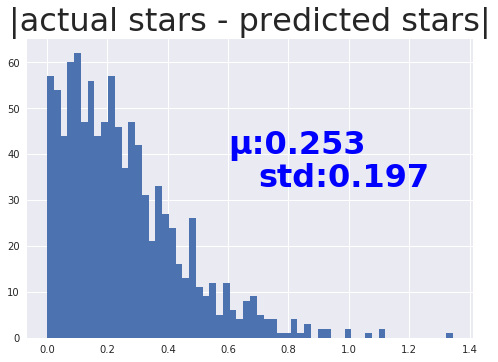

In [64]:
# Stars
plt.hist(onekproducts['star_error'], bins=60);
plt.title('|actual stars - predicted stars|', fontsize=32)
mean = round(np.mean(onekproducts['star_error']),3)
std = round(np.std(onekproducts['star_error']),3)
plt.text(.6,40,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(.7,33,'std:'+str(std), weight='bold', fontsize=32, color='blue')

Text(0.875, 30, 'std:2.9%')

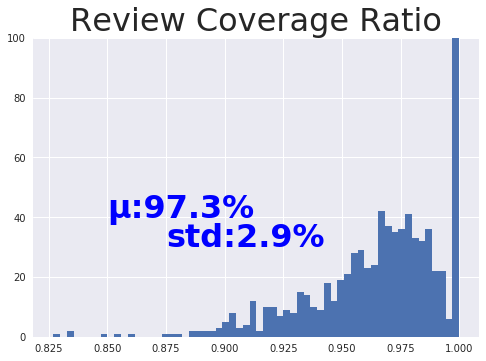

In [62]:
# Review Coverage
plt.hist(onekproducts['coverage_ratio'], bins=60);
plt.title('Review Coverage Ratio', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts['coverage_ratio'])*100,1)
std = round(np.std(onekproducts['coverage_ratio'])*100,1)
plt.text(.85,40,'μ:'+str(mean)+'%', weight='bold', fontsize=32, color='blue')
plt.text(.875,30,'std:'+str(std)+'%', weight='bold', fontsize=32, color='blue')

Text(0.85, 30, 'std:3.4%')

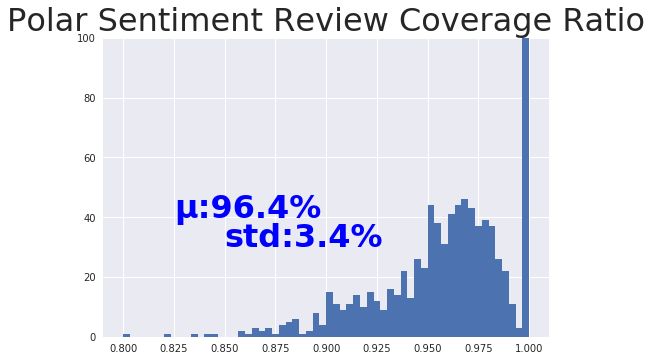

In [56]:
# Polar Review Coverage
plt.hist(onekproducts['polar_coverage_ratio'], bins=60);
plt.title('Polar Sentiment Review Coverage Ratio', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts['polar_coverage_ratio'])*100,1)
std = round(np.std(onekproducts['polar_coverage_ratio'])*100,1)
plt.text(.825,40,'μ:'+str(mean)+'%', weight='bold', fontsize=32, color='blue')
plt.text(.85,30,'std:'+str(std)+'%', weight='bold', fontsize=32, color='blue')

Text(30, 30, 'std:12.629')

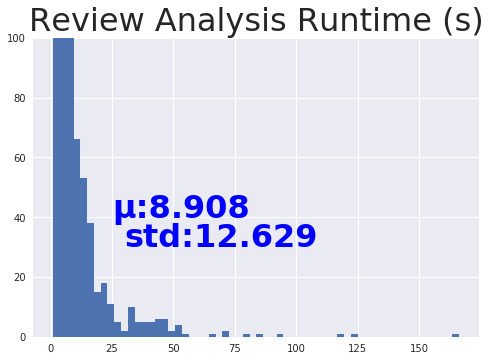

In [57]:
# Runtime
plt.hist(onekproducts['runtime(s)'], bins=60);
plt.title('Review Analysis Runtime (s)', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts['runtime(s)']),3)
std = round(np.std(onekproducts['runtime(s)']),3)
plt.text(25,40,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(30,30,'std:'+str(std), weight='bold', fontsize=32, color='blue')

Text(220, 30, 'std:116.1')

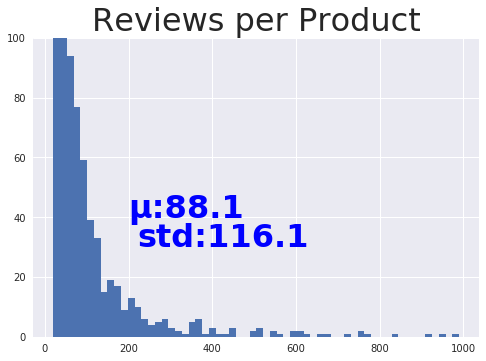

In [58]:
# Review Counts
plt.hist(onekproducts.review_count, bins=60);
plt.title('Reviews per Product', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts.review_count),1)
std = round(np.std(onekproducts.review_count),1)
plt.text(200,40,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(220,30,'std:'+str(std), weight='bold', fontsize=32, color='blue')


Text(9, 45, 'std:1.5')

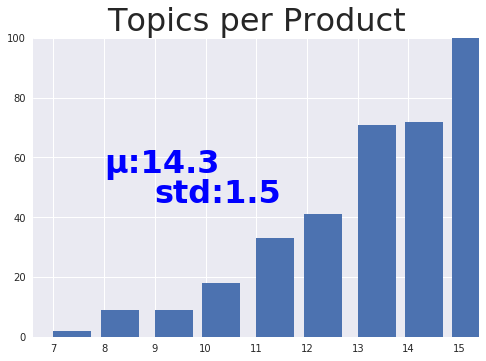

In [59]:
# Total topics

plt.hist(onekproducts.total_topics, bins=60, width=0.75);
plt.title('Topics per Product', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts.total_topics),1)
std = round(np.std(onekproducts.total_topics),1)
plt.text(8,55,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(9,45,'std:'+str(std), weight='bold', fontsize=32, color='blue')

Text(110, 45, 'std:32.0')

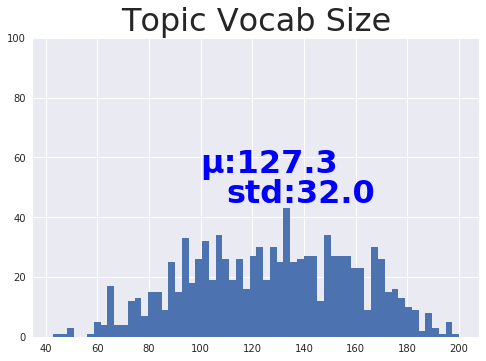

In [61]:
# Total topics

plt.hist(onekproducts.vocab_size, bins=60);
plt.title('Topic Vocab Size', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts.vocab_size),1)
std = round(np.std(onekproducts.vocab_size),1)
plt.text(100,55,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(110,45,'std:'+str(std), weight='bold', fontsize=32, color='blue')